# Perform single-cell quality control

In this notebook, we perform single-cell quality control. To filter the single-cells, we use z-score to find outliers using the values from only one feature at a time. We use features from the AreaShape and Intensity modle to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. To identify these nuclei, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. 
We detect nuclei that are abnormally large, which likely indicates poor nucleus segmentation where overlapping nuclei are merged into one segmentation. 
- **Nuclei Intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. 
In combination with abnormally large nuclei, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

As well, there are times where nuclei are under or over-segmented, leading to non-circular nuclei shapes. To identify these nuclei, we use:

- **Nuclei FormFactor:** This metric quantifies how circular an object is, with 1 meaning perfect circle and 0 meaning non-circular. 
We are detecting nuclei that are not circular and have rough edges or shapes that look like budding yeast.

### Assessing poor cell segmentation

Also due to high confluence, images with large, intense clusters of cells leads to errors in the segmentation algorithm that causes cells around the cluster to segmented incorrectly. 
When this happens, a cell is segmented around the same segmentation as the nucleus, giving it the same area which is very small for a normal cardiac fibroblast cell. To detect poorly segmented cells, we use:

- **Cells area in conjunction with nuclei area:** The Cells Area metric quantifies the number of pixels in a cell segmentation.
We detect cells that are abnormally small using nuclei area as the threshold to try and avoid removing too many properly segmented cells. 
We find cells that are with 2 standard deviations above the nuclei mean are more likely  to be poor cell segmentation due to high confluence clusters.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

## Set paths and variables

In [2]:
# Set outlier threshold to use for all metrics (# of std deviations away from the mean)
outlier_threshold = 2

# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Set plate as variable to load in
plate = "localhost220513100001_KK22-05-198_FactinAdjusted"

# Load in converted plate data
plate_df = pd.read_parquet(f"{data_dir}/{plate}_converted.parquet")

# Add plate values if plate_4 is loaded in as it is absent due to error
if plate == 'localhost231120090001':
    plate_df['Image_Metadata_Plate'] = 'localhost231120090001'

print(plate_df.shape)
plate_df.head()

(11791, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,419.488971,115.273897,423.043530,103.325259,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,2,...,2.435366,2.437117,0.274758,0.288000,0.279136,0.261363,0.452281,0.439173,0.448468,0.432924
1,155.131181,149.960852,163.177967,171.310538,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,4,...,6.588626,6.319666,12.619880,13.318648,16.168438,12.400382,6.643136,6.964105,7.965709,6.458424
2,267.911913,236.579061,253.734547,229.137312,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,6,...,2.611762,2.633422,0.584105,0.596045,0.573217,0.531702,0.450994,0.452684,0.473842,0.456478
3,857.376923,235.650000,852.091760,215.798949,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,7,...,1.637578,1.649070,0.309415,0.281101,0.279176,0.272288,0.389012,0.378720,0.389834,0.376039
4,334.372617,239.728769,350.207060,235.500467,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,8,...,3.853535,3.735811,0.291262,0.293725,0.319546,0.293218,0.282559,0.277520,0.302190,0.290864


## Identify mis-segmented nuclei from large clusters

### Perform z-scoring to identify nuclei outliers

In [3]:
# Determine z-score using only Nuclei Area and Nuclei Intensity from Nuclei channel
plate_df["Z_Score_Area"] = zscore(plate_df["Nuclei_AreaShape_Area"])
plate_df["Z_Score_Intensity"] = zscore(
    plate_df["Nuclei_Intensity_IntegratedIntensity_Hoechst"]
)

# Filter DataFrame for outliers
nuclei_outliers_df = plate_df[
    (plate_df["Z_Score_Area"].abs() > outlier_threshold)
    & (plate_df["Z_Score_Intensity"].abs() > outlier_threshold)
]

# Print outliers to assess how it detected outliers
print(nuclei_outliers_df.shape[0])
# Print the range of outliers
print("Outliers Range:")
print("Area Min:", nuclei_outliers_df['Nuclei_AreaShape_Area'].min())
print("Area Max:", nuclei_outliers_df['Nuclei_AreaShape_Area'].max())
print("Intensity Min:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].min())
print("Intensity Max:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].max())
nuclei_outliers_df[
    [
        "Nuclei_AreaShape_Area",
        "Nuclei_Intensity_IntegratedIntensity_Hoechst",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_Area", ascending=True).head()

186
Outliers Range:
Area Min: 2818.0
Area Max: 7790.0
Intensity Min: 145.95803795196116
Intensity Max: 936.3163515180349


,Nuclei_AreaShape_Area,Nuclei_Intensity_IntegratedIntensity_Hoechst,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
8673,2818.0,230.657374,G10,f02,540.565649,777.234209
8706,2819.0,158.877012,F10,f01,435.307911,995.431359
11110,2822.0,156.422065,H12,f07,417.263643,303.890503
3195,2837.0,256.005188,D10,f11,84.830102,714.225238
11621,2838.0,151.374441,H12,f05,482.013742,929.267089


### Scatter plot of single-cells based on Nuclei Area and Intensity

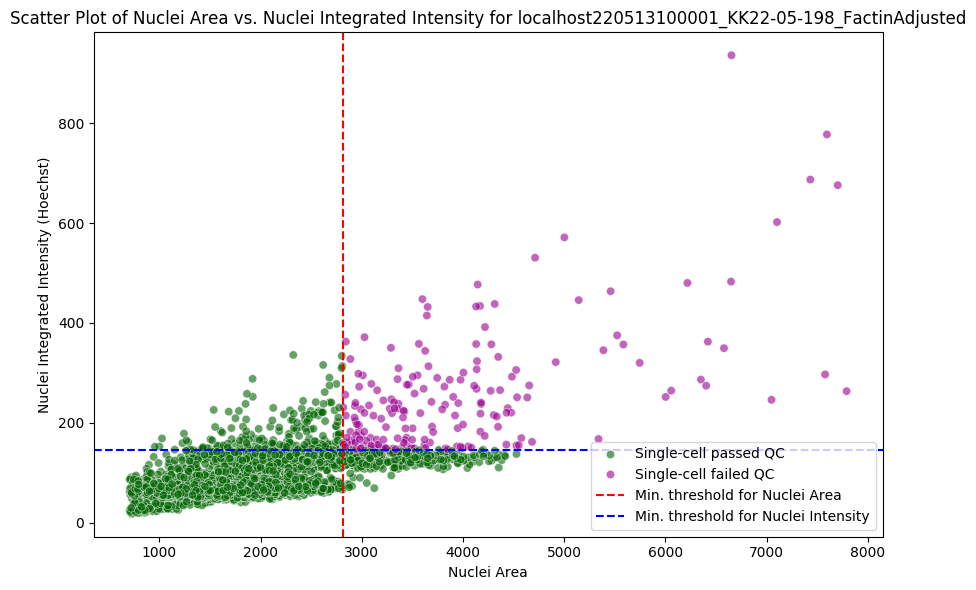

In [4]:
# Set the default value to 'inlier'
plate_df['Outlier_Status'] = 'Single-cell passed QC'

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_df.loc[plate_df.index.isin(nuclei_outliers_df.index), 'Outlier_Status'] = 'Single-cell failed QC'

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_AreaShape_Area",
    y="Nuclei_Intensity_IntegratedIntensity_Hoechst",
    hue="Outlier_Status",
    palette={'Single-cell passed QC': '#006400', 'Single-cell failed QC': '#990090'},  # Specify colors
    alpha=0.6
)

# Add threshold lines
plt.axvline(
    x=nuclei_outliers_df['Nuclei_AreaShape_Area'].min(),
    color="r",
    linestyle="--",
    label='Min. threshold for Nuclei Area'
)
plt.axhline(
    y=nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].min(),
    color="b",
    linestyle="--",
    label='Min. threshold for Nuclei Intensity'
)

plt.title(f"Scatter Plot of Nuclei Area vs. Nuclei Integrated Intensity for {plate}")
plt.xlabel("Nuclei Area")
plt.ylabel("Nuclei Integrated Intensity (Hoechst)")
plt.tight_layout()

# Show the legend
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0), prop={'size': 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()


## Identify mis-segmented nuclei across all sizes

In [5]:
# Determine z-score using only Nuclei FormFactor
plate_df["Z_Score_FormFactor"] = zscore(plate_df["Nuclei_AreaShape_FormFactor"])

# Filter DataFrame for outliers
formfactor_outliers_df = plate_df[
    (plate_df["Z_Score_FormFactor"].abs() > outlier_threshold)
]

# Print outliers to assess how it detected outliers
print(formfactor_outliers_df.shape[0])
# Print the range of outliers
print("Outliers Range:")
print("Area Min:", formfactor_outliers_df["Nuclei_AreaShape_FormFactor"].min())
print("Area Max:", formfactor_outliers_df["Nuclei_AreaShape_FormFactor"].max())
formfactor_outliers_df[
    [
        "Nuclei_AreaShape_FormFactor",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_FormFactor", ascending=True)

523
Outliers Range:
Area Min: 0.11746847245038096
Area Max: 0.7150359270366188


,Nuclei_AreaShape_FormFactor,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
2971,0.117468,D10,f01,555.149458,265.150903
8035,0.183055,G10,f02,187.406977,164.118393
8764,0.187617,F10,f05,601.681600,680.365600
9113,0.205511,G10,f09,196.740278,453.209722
6947,0.211865,E11,f05,805.702020,877.285354
...,...,...,...,...,...
9786,0.714454,G11,f06,178.036568,1002.305576
6776,0.714534,E09,f14,342.523810,149.533101
7893,0.714996,G09,f09,300.051310,247.578603
4749,0.715033,E09,f02,850.685315,514.296885


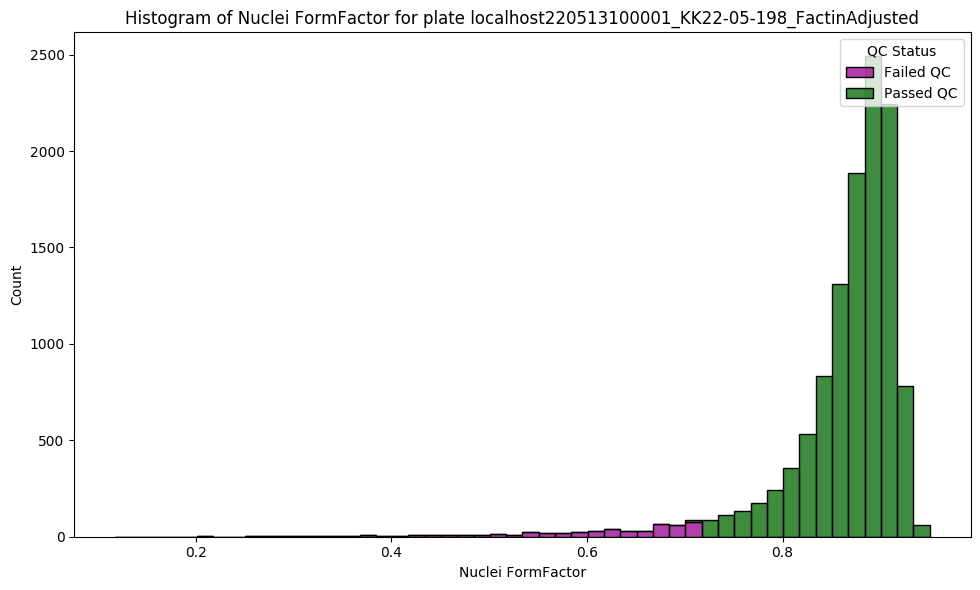

In [6]:
# Reset the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_df.loc[plate_df.index.isin(formfactor_outliers_df.index), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=plate_df,
    x="Nuclei_AreaShape_FormFactor",
    hue="Outlier_Status",
    multiple="stack",
    bins=50,  # Adjust the number of bins as needed
    palette={"Single-cell passed QC": "#006400", "Single-cell failed QC": "#990090"},
    legend=True,
)

plt.title(f"Histogram of Nuclei FormFactor for plate {plate}")
plt.xlabel("Nuclei FormFactor")
plt.ylabel("Count")
plt.tight_layout()

# Show the legend
plt.legend(
    title="QC Status",
    loc="upper right",
    prop={"size": 10},
    labels=["Failed QC", "Passed QC"],
)

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_formfactor_outliers.png"), dpi=500)

plt.show()

## Identify mis-segmented cells due to high confluence

### Using nuclei area, we find the threshold of this feature 2 standard deviations above the mean to use for identifying outlier cells.

Note: We found using the z-scoring method with the cells area lead to removing a high number of single-cells that included many properly segmented single-cells. Using the nuclei area to threshold the cells area was better able to properly filter poorly segmented cells due to high confluence.

In [7]:
# Calculate the mean and standard deviation of Nuclei_AreaShape_Area
mean_nuclei_area = plate_df["Nuclei_AreaShape_Area"].mean()
std_nuclei_area = plate_df["Nuclei_AreaShape_Area"].std()

# Calculate the threshold for filtering cells which is the number of standard deviations above the mean for nuclei
outlier_threshold = mean_nuclei_area + outlier_threshold * std_nuclei_area

# Filter DataFrame for cells with area below the threshold
cells_outliers_df = plate_df[
    plate_df["Cells_AreaShape_Area"] <= outlier_threshold
]

# Print the filtered DataFrame shape to check the number of cells filtered
print(cells_outliers_df.shape[0])

# Print the range of filtered cells' areas
print("Outlier Cells' Area Range:")
print("Area Min:", cells_outliers_df["Cells_AreaShape_Area"].min())
print("Area Max:", cells_outliers_df["Cells_AreaShape_Area"].max())

# Print specific columns of filtered cells DataFrame
print("Outlier Cells:")
cells_outliers_df[
    [
        "Cells_AreaShape_Area",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Cells_AreaShape_Area", ascending=True)


1683
Outlier Cells' Area Range:
Area Min: 762.0
Area Max: 2811.0
Outlier Cells:


,Cells_AreaShape_Area,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
11322,762.0,H12,f15,1061.702100,654.438320
850,778.0,B12,f03,981.040103,252.668823
8462,783.0,G10,f08,320.217966,667.538970
11086,784.0,H11,f14,938.603316,824.783163
10365,798.0,H10,f04,779.884712,720.646617
...,...,...,...,...,...
6168,2806.0,E10,f00,384.734223,541.432039
5024,2807.0,E09,f04,231.283996,686.919519
8077,2809.0,G10,f02,223.370836,853.618801
6943,2810.0,E11,f05,457.065116,552.321595


### Box plot separating single-cells by outlier status to see the distribution of cells area

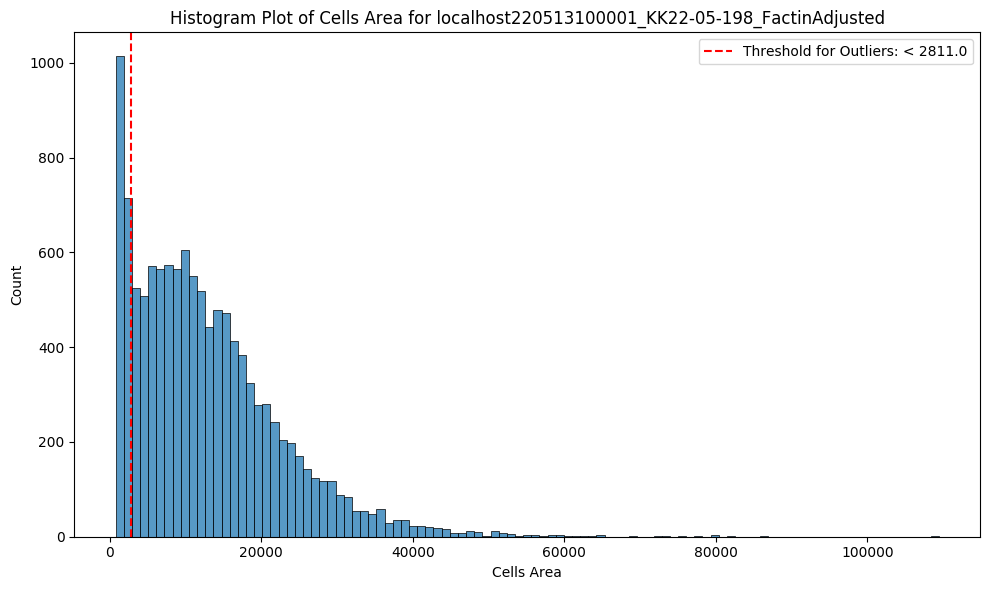

In [8]:
# Create a density plot
plt.figure(figsize=(10, 6))
sns.histplot(x='Cells_AreaShape_Area', data=plate_df, fill=True)

# Add threshold line
plt.axvline(
    x=cells_outliers_df["Cells_AreaShape_Area"].max(),
    color="r",
    linestyle="--",
    label=f'Threshold for Outliers: < {cells_outliers_df["Cells_AreaShape_Area"].max()}',
)

# Set labels and title
plt.ylabel('Count')
plt.xlabel('Cells Area')
plt.title(f'Histogram Plot of Cells Area for {plate}')
plt.legend()
plt.tight_layout()

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)

# Show the plot
plt.show()

## Remove all outliers and save cleaned data frame

In [9]:
# Assuming nuclei_outliers_df and cells_outliers_df have the same index
outlier_indices = pd.concat([nuclei_outliers_df, cells_outliers_df, formfactor_outliers_df]).index

# Remove rows with outlier indices from plate_4_df
plate_4_df_cleaned = plate_df.drop(outlier_indices)

# Remove columns from z-scoring or assigning outliers (not included for downstream analysis)
plate_4_df_cleaned = plate_4_df_cleaned.drop(
    columns=["Z_Score_Area", "Z_Score_Intensity", "Z_Score_FormFactor", "Outlier_Status", "is_outlier"],
    errors="ignore",
)

# Save cleaned data for this plate
plate_name = plate_df['Image_Metadata_Plate'].iloc[0]
plate_4_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_4_df_cleaned.shape)
plate_4_df_cleaned.head()

(9526, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,419.488971,115.273897,423.043530,103.325259,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,2,...,2.435366,2.437117,0.274758,0.288000,0.279136,0.261363,0.452281,0.439173,0.448468,0.432924
1,155.131181,149.960852,163.177967,171.310538,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,4,...,6.588626,6.319666,12.619880,13.318648,16.168438,12.400382,6.643136,6.964105,7.965709,6.458424
2,267.911913,236.579061,253.734547,229.137312,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,6,...,2.611762,2.633422,0.584105,0.596045,0.573217,0.531702,0.450994,0.452684,0.473842,0.456478
3,857.376923,235.650000,852.091760,215.798949,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,7,...,1.637578,1.649070,0.309415,0.281101,0.279176,0.272288,0.389012,0.378720,0.389834,0.376039
4,334.372617,239.728769,350.207060,235.500467,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,8,...,3.853535,3.735811,0.291262,0.293725,0.319546,0.293218,0.282559,0.277520,0.302190,0.290864
